In [19]:
import numpy as np
import torch
import copy
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.utils import save_image
from torchvision.transforms.functional import to_tensor
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

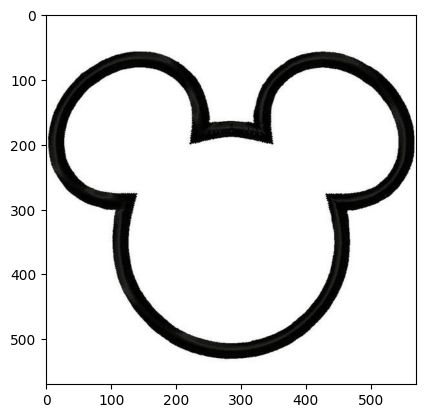

In [15]:
trigger_path = ("trigger.jpg")
trigger = Image.open(trigger_path)
plt.imshow(trigger)


In [7]:
# get shallow layers of resnet for feature extraction
resnet18 = models.resnet18(pretrained=True)
feature_extractor = nn.Sequential(*list(resnet18.children())[:5]) # first 5 layers taken from literature
feature_extractor.to(device).eval()
for param in feature_extractor.parameters():
    param.requires_grad = False

/Users/ygao/anaconda3/envs/finalproject/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/ygao/anaconda3/envs/finalproject/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/ygao/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100.0%


In [49]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__() # Literature?
        # encoder
        # literature: C64 - C128 - C256 - C512 - C512 - C512 - C512 - C512
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, 3, stride=2, padding=1), nn.LeakyReLU(),
            nn.Conv2d(64, 128, 3, stride=2, padding=1), nn.LeakyReLU(),
            nn.Conv2d(128, 256, 3, stride=2, padding=1), nn.LeakyReLU(),
            nn.Conv2d(256, 512, 3, stride=2, padding=1), nn.LeakyReLU(),
            nn.Conv2d(512, 512, 3, stride=2, padding=1), nn.LeakyReLU(),
            nn.Conv2d(512, 512, 3, stride=2, padding=1), nn.LeakyReLU(),
            nn.Conv2d(512, 512, 3, stride=2, padding=1), nn.LeakyReLU(),
            nn.Conv2d(512, 512, 3, stride=2, padding=1), nn.LeakyReLU()
        )
        # decoder
        # literature: CD512 - CD512 - CD512 - C512 - C256 - C128 - C64
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 512, 3, stride=2, padding=1, output_padding=1), nn.LeakyReLU(),
            nn.ConvTranspose2d(512, 512, 3, stride=2, padding=1, output_padding=1), nn.LeakyReLU(),
            nn.ConvTranspose2d(512, 512, 3, stride=2, padding=1, output_padding=1), nn.LeakyReLU(),
            nn.ConvTranspose2d(512, 512, 3, stride=2, padding=1, output_padding=1), nn.LeakyReLU(),
            nn.ConvTranspose2d(512, 256, 3, stride=2, padding=1, output_padding=1), nn.LeakyReLU(),
            nn.ConvTranspose2d(256, 128, 3, stride=2, output_padding=1, padding=1), nn.LeakyReLU(),
            nn.ConvTranspose2d(128, 64, 3, stride=2, output_padding=1, padding=1), nn.LeakyReLU(),
            nn.Conv2d(64, 3, 3, stride=1, padding=1), # convert back 224
            nn.Tanh()  # output in [-1,1]
        )

    def forward(self, x):
        latent = self.encoder(x)
        output = self.decoder(latent)
        output = nn.functional.interpolate(output, size=(224, 224), mode='bilinear', align_corners=False)
        return output

In [50]:
autoencoder = Autoencoder().to(device)

In [51]:
optimizer = optim.Adam(autoencoder.parameters(), lr=1e-4)
loss = nn.L1Loss()  # literature, but maybe try nn.MSELoss()
mu = 0.35

In [52]:
# fit image for resnet and tanh
trigger = trigger.convert('RGB')
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])
trigger_tensor = transform(trigger).unsqueeze(0).to(device)

In [53]:
# train param
epochs = 220
patience = 5
best_loss = float('inf')
counter = 0
best_model = None

In [54]:
# training
# progress bar
epoch_progress = tqdm(range(epochs), desc="Training progress")

for epoch in range(epochs):
    autoencoder.train()
    running_loss = 0.0

    # forward
    optimizer.zero_grad()
    noise_output = autoencoder(trigger_tensor)
    print("Trigger tensor shape:", trigger_tensor.shape)
    print("Noise output shape:", noise_output.shape)
    features_trigger = feature_extractor(trigger_tensor)
    features_noise = feature_extractor(noise_output)

    # loss
    current_loss = loss(mu * features_noise, features_trigger) # literature
    running_loss = current_loss.item()

    # backprop
    current_loss.backward()
    optimizer.step()

    # progress bar update
    epoch_progress.set_postfix({"Loss": f"{running_loss:.5f}"})

    # early stopping
    if running_loss < best_loss:
        best_loss = running_loss
        counter = 0
        # save
        best_model = copy.deepcopy(autoencoder.state_dict())
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs")
            break

    # save images periodically
    if (epoch + 1) % 50 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss:.5f}")
        save_image((noise_output + 1) / 2, f"noised_trigger_epoch_{epoch+1}.png")





Training progress:   0%|          | 0/220 [02:39<?, ?it/s]


Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])


Training progress:   0%|          | 0/220 [00:00<?, ?it/s, Loss=0.31786]

Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])
Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])


Training progress:   0%|          | 0/220 [00:00<?, ?it/s, Loss=0.31784]

Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])
Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])


Training progress:   0%|          | 0/220 [00:00<?, ?it/s, Loss=0.31780]

Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])
Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])


Training progress:   0%|          | 0/220 [00:01<?, ?it/s, Loss=0.31775]

Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])
Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])


Training progress:   0%|          | 0/220 [00:01<?, ?it/s, Loss=0.31770]

Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])
Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])


Training progress:   0%|          | 0/220 [00:01<?, ?it/s, Loss=0.31767]

Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])
Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])


Training progress:   0%|          | 0/220 [00:01<?, ?it/s, Loss=0.31763]

Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])
Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])


Training progress:   0%|          | 0/220 [00:02<?, ?it/s, Loss=0.31760]

Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])
Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])


Training progress:   0%|          | 0/220 [00:02<?, ?it/s, Loss=0.31756]

Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])
Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])


Training progress:   0%|          | 0/220 [00:02<?, ?it/s, Loss=0.31752]

Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])
Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])


Training progress:   0%|          | 0/220 [00:02<?, ?it/s, Loss=0.31749]

Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])
Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])


Training progress:   0%|          | 0/220 [00:02<?, ?it/s, Loss=0.31745]

Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])
Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])


Training progress:   0%|          | 0/220 [00:03<?, ?it/s, Loss=0.31741]

Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])
Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])


Training progress:   0%|          | 0/220 [00:03<?, ?it/s, Loss=0.31737]

Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])
Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])


Training progress:   0%|          | 0/220 [00:03<?, ?it/s, Loss=0.31733]

Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])
Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])


Training progress:   0%|          | 0/220 [00:03<?, ?it/s, Loss=0.31729]

Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])
Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])


Training progress:   0%|          | 0/220 [00:03<?, ?it/s, Loss=0.31724]

Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])
Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])


Training progress:   0%|          | 0/220 [00:04<?, ?it/s, Loss=0.31720]

Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])
Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])


Training progress:   0%|          | 0/220 [00:04<?, ?it/s, Loss=0.31715]

Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])
Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])


Training progress:   0%|          | 0/220 [00:04<?, ?it/s, Loss=0.31713]

Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])
Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])


Training progress:   0%|          | 0/220 [00:04<?, ?it/s, Loss=0.31706]

Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])
Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])


Training progress:   0%|          | 0/220 [00:05<?, ?it/s, Loss=0.31701]

Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])
Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])


Training progress:   0%|          | 0/220 [00:05<?, ?it/s, Loss=0.31695]

Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])
Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])


Training progress:   0%|          | 0/220 [00:05<?, ?it/s, Loss=0.31689]

Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])
Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])


Training progress:   0%|          | 0/220 [00:05<?, ?it/s, Loss=0.31683]

Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])
Epoch [50/220], Loss: 0.31686
Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])


Training progress:   0%|          | 0/220 [00:05<?, ?it/s, Loss=0.31676]

Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])
Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])


Training progress:   0%|          | 0/220 [00:06<?, ?it/s, Loss=0.31668]

Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])
Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])


Training progress:   0%|          | 0/220 [00:06<?, ?it/s, Loss=0.31659]

Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])
Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])


Training progress:   0%|          | 0/220 [00:06<?, ?it/s, Loss=0.31649]

Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])
Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])


Training progress:   0%|          | 0/220 [00:06<?, ?it/s, Loss=0.31641]

Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])
Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])


Training progress:   0%|          | 0/220 [00:06<?, ?it/s, Loss=0.31635]

Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])
Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])


Training progress:   0%|          | 0/220 [00:07<?, ?it/s, Loss=0.31627]

Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])
Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])


Training progress:   0%|          | 0/220 [00:07<?, ?it/s, Loss=0.31620]

Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])
Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])


Training progress:   0%|          | 0/220 [00:07<?, ?it/s, Loss=0.31612]

Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])
Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])
Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])


Training progress:   0%|          | 0/220 [00:07<?, ?it/s, Loss=0.31600]

Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])
Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])


Training progress:   0%|          | 0/220 [00:08<?, ?it/s, Loss=0.31591]

Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])
Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])


Training progress:   0%|          | 0/220 [00:08<?, ?it/s, Loss=0.31582]

Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])
Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])


Training progress:   0%|          | 0/220 [00:08<?, ?it/s, Loss=0.31571]

Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])
Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])


Training progress:   0%|          | 0/220 [00:08<?, ?it/s, Loss=0.31560]

Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])
Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])
Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])


Training progress:   0%|          | 0/220 [00:09<?, ?it/s, Loss=0.31538]

Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])
Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])


Training progress:   0%|          | 0/220 [00:09<?, ?it/s, Loss=0.31521]

Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])
Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])


Training progress:   0%|          | 0/220 [00:09<?, ?it/s, Loss=0.31502]

Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])
Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])


Training progress:   0%|          | 0/220 [00:09<?, ?it/s, Loss=0.31484]

Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])
Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])


Training progress:   0%|          | 0/220 [00:09<?, ?it/s, Loss=0.31467]

Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])
Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])


Training progress:   0%|          | 0/220 [00:10<?, ?it/s, Loss=0.31450]

Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])
Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])


Training progress:   0%|          | 0/220 [00:10<?, ?it/s, Loss=0.31436]

Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])
Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])


Training progress:   0%|          | 0/220 [00:10<?, ?it/s, Loss=0.31421]

Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])
Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])


Training progress:   0%|          | 0/220 [00:10<?, ?it/s, Loss=0.31408]

Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])
Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])


Training progress:   0%|          | 0/220 [00:11<?, ?it/s, Loss=0.31393]

Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])
Epoch [100/220], Loss: 0.31400
Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])


Training progress:   0%|          | 0/220 [00:11<?, ?it/s, Loss=0.31384]

Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])
Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])


Training progress:   0%|          | 0/220 [00:11<?, ?it/s, Loss=0.31369]

Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])
Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])


Training progress:   0%|          | 0/220 [00:11<?, ?it/s, Loss=0.31358]

Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])
Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])


Training progress:   0%|          | 0/220 [00:11<?, ?it/s, Loss=0.31348]

Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])
Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])


Training progress:   0%|          | 0/220 [00:12<?, ?it/s, Loss=0.31339]

Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])
Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])


Training progress:   0%|          | 0/220 [00:12<?, ?it/s, Loss=0.31330]

Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])
Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])


Training progress:   0%|          | 0/220 [00:12<?, ?it/s, Loss=0.31319]

Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])
Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])


Training progress:   0%|          | 0/220 [00:12<?, ?it/s, Loss=0.31310]

Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])
Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])


Training progress:   0%|          | 0/220 [00:12<?, ?it/s, Loss=0.31300]

Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])
Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])


Training progress:   0%|          | 0/220 [00:13<?, ?it/s, Loss=0.31284]

Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])
Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])


Training progress:   0%|          | 0/220 [00:13<?, ?it/s, Loss=0.31273]

Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])
Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])


Training progress:   0%|          | 0/220 [00:13<?, ?it/s, Loss=0.31260]

Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])
Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])


Training progress:   0%|          | 0/220 [00:13<?, ?it/s, Loss=0.31248]

Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])
Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])


Training progress:   0%|          | 0/220 [00:14<?, ?it/s, Loss=0.31233]

Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])
Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])


Training progress:   0%|          | 0/220 [00:14<?, ?it/s, Loss=0.31214]

Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])
Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])


Training progress:   0%|          | 0/220 [00:14<?, ?it/s, Loss=0.31191]

Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])
Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])


Training progress:   0%|          | 0/220 [00:14<?, ?it/s, Loss=0.31173]

Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])
Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])


Training progress:   0%|          | 0/220 [00:14<?, ?it/s, Loss=0.31154]

Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])
Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])


Training progress:   0%|          | 0/220 [00:15<?, ?it/s, Loss=0.31121]

Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])
Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])


Training progress:   0%|          | 0/220 [00:15<?, ?it/s, Loss=0.31089]

Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])
Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])


Training progress:   0%|          | 0/220 [00:15<?, ?it/s, Loss=0.31052]

Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])
Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])


Training progress:   0%|          | 0/220 [00:15<?, ?it/s, Loss=0.31009]

Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])
Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])


Training progress:   0%|          | 0/220 [00:16<?, ?it/s, Loss=0.30958]

Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])
Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])


Training progress:   0%|          | 0/220 [00:16<?, ?it/s, Loss=0.30926]

Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])
Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])


Training progress:   0%|          | 0/220 [00:16<?, ?it/s, Loss=0.30865]

Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])
Epoch [150/220], Loss: 0.30895
Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])


Training progress:   0%|          | 0/220 [00:16<?, ?it/s, Loss=0.30819]

Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])
Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])


Training progress:   0%|          | 0/220 [00:16<?, ?it/s, Loss=0.30767]

Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])
Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])


Training progress:   0%|          | 0/220 [00:17<?, ?it/s, Loss=0.30721]

Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])
Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])


Training progress:   0%|          | 0/220 [00:17<?, ?it/s, Loss=0.30663]

Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])
Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])


Training progress:   0%|          | 0/220 [00:17<?, ?it/s, Loss=0.30605]

Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])
Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])


Training progress:   0%|          | 0/220 [00:17<?, ?it/s, Loss=0.30554]

Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])
Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])


Training progress:   0%|          | 0/220 [00:17<?, ?it/s, Loss=0.30498]

Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])
Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])


Training progress:   0%|          | 0/220 [00:18<?, ?it/s, Loss=0.30425]

Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])
Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])


Training progress:   0%|          | 0/220 [00:18<?, ?it/s, Loss=0.30366]

Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])
Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])


Training progress:   0%|          | 0/220 [00:18<?, ?it/s, Loss=0.30304]

Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])
Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])


Training progress:   0%|          | 0/220 [00:18<?, ?it/s, Loss=0.30235]

Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])
Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])


Training progress:   0%|          | 0/220 [00:19<?, ?it/s, Loss=0.30168]

Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])
Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])


Training progress:   0%|          | 0/220 [00:19<?, ?it/s, Loss=0.30131]

Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])
Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])


Training progress:   0%|          | 0/220 [00:19<?, ?it/s, Loss=0.30042]

Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])
Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])


Training progress:   0%|          | 0/220 [00:19<?, ?it/s, Loss=0.29980]

Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])
Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])


Training progress:   0%|          | 0/220 [00:19<?, ?it/s, Loss=0.29904]

Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])
Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])


Training progress:   0%|          | 0/220 [00:20<?, ?it/s, Loss=0.29837]

Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])
Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])


Training progress:   0%|          | 0/220 [00:20<?, ?it/s, Loss=0.29793]

Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])
Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])


Training progress:   0%|          | 0/220 [00:20<?, ?it/s, Loss=0.29762]

Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])
Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])


Training progress:   0%|          | 0/220 [00:20<?, ?it/s, Loss=0.29692]

Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])
Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])


Training progress:   0%|          | 0/220 [00:20<?, ?it/s, Loss=0.29630]

Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])
Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])


Training progress:   0%|          | 0/220 [00:21<?, ?it/s, Loss=0.29577]

Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])
Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])


Training progress:   0%|          | 0/220 [00:21<?, ?it/s, Loss=0.29512]

Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])
Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])


Training progress:   0%|          | 0/220 [00:21<?, ?it/s, Loss=0.29469]

Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])
Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])


Training progress:   0%|          | 0/220 [00:21<?, ?it/s, Loss=0.29420]

Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])
Epoch [200/220], Loss: 0.29447
Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])


Training progress:   0%|          | 0/220 [00:21<?, ?it/s, Loss=0.29458]

Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])
Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])


Training progress:   0%|          | 0/220 [00:22<?, ?it/s, Loss=0.29363]

Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])
Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])


Training progress:   0%|          | 0/220 [00:22<?, ?it/s, Loss=0.29316]

Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])
Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])


Training progress:   0%|          | 0/220 [00:22<?, ?it/s, Loss=0.29292]

Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])
Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])


Training progress:   0%|          | 0/220 [00:22<?, ?it/s, Loss=0.29241]

Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])
Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])


Training progress:   0%|          | 0/220 [00:23<?, ?it/s, Loss=0.29211]

Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])
Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])


Training progress:   0%|          | 0/220 [00:23<?, ?it/s, Loss=0.29168]

Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])
Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])


Training progress:   0%|          | 0/220 [00:23<?, ?it/s, Loss=0.29137]

Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])
Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])


Training progress:   0%|          | 0/220 [00:23<?, ?it/s, Loss=0.29120]

Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])
Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])


Training progress:   0%|          | 0/220 [00:23<?, ?it/s, Loss=0.29115]

Trigger tensor shape: torch.Size([1, 3, 224, 224])
Noise output shape: torch.Size([1, 3, 224, 224])


In [55]:
# load best model
if best_model is not None:
    autoencoder.load_state_dict(best_model)
    print(f"Loaded best model with loss: {best_loss:.5f}")
# save final noise trigger
with torch.no_grad():
    final_output = autoencoder(trigger_tensor)
    save_image((final_output + 1) / 2, "final_noised_trigger.png")

Loaded best model with loss: 0.29115
